In [1]:

import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

# from src.utils.hf_utils import download_weights
# from src.utils.vit_config import inizialize_model
from src.data.dataset import PatchFromH5Dataset, stratified_split, plot_class_distributions
from src.rl.train import ModelTrainer, TrainingArguments

from src.rl.modelling import ViT_UCB_Pruning


/home/vcivale/UNI_UCB2/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
IMG_SIZE = 224
TRAIN_BATCH_SIZE = 8
NUM_EPOCHS = 70

In [3]:
dataset = PatchFromH5Dataset(
    h5_dir='/equilibrium/datasets/TCGA-histological-data/hest/patches/patches/',
    transform=transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),])
)

Unique labels in metadata: {'ALL', 'READ', 'CESC', 'COADREAD', 'LIHB', 'Healthy', 'IDC', 'COAD', 'ACYC', 'ILC', 'SOC', 'MEL', 'HCC', 'UNKNOWN', 'LNET', 'PRCC', 'LUAD', 'PAAD', 'SCCRCC', 'SKCM', 'CSCC', 'EPM', 'PRAD', 'LUSC', 'GBM', 'BLCA', 'HGSOC'}
Labels used: ['Healthy', 'SKCM', 'PRAD', 'COAD', 'MEL', 'HGSOC', 'LUAD', 'PAAD', 'COADREAD', 'GBM', 'ALL', 'HCC', 'PRCC', 'IDC', 'ILC', 'LNET', 'LUSC', 'SOC', 'CESC', 'READ', 'SCCRCC', 'BLCA', 'ACYC', 'CSCC', 'EPM', 'LIHB', 'UNKNOWN']
Sample to label mapping example: [('TENX159', 'Healthy'), ('TENX158', 'SKCM'), ('TENX157', 'PRAD'), ('TENX156', 'COAD'), ('TENX155', 'COAD'), ('TENX154', 'COAD'), ('TENX153', 'Healthy'), ('TENX152', 'COAD'), ('TENX149', 'COAD'), ('TENX148', 'COAD')]


In [4]:
train_idx, val_idx, test_idx = stratified_split(dataset, test_size=0.3, val_size=0.3, random_state=42)

07/19/2025 12:03:38 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
07/19/2025 12:03:38 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


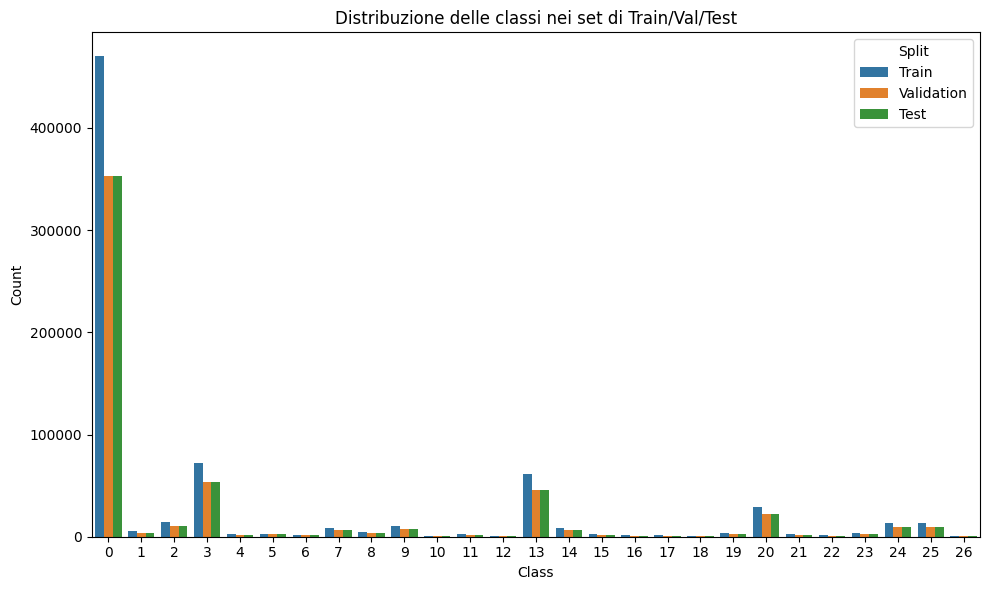

In [5]:
plot_class_distributions(train_idx, val_idx, test_idx, full_dataset=dataset)

In [6]:
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=16, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False, num_workers=16, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False, num_workers=16, drop_last=True)

In [8]:
labels_num = len(dataset.labels)

print(f"Number of classes: {labels_num}")
model = ViT_UCB_Pruning(model_name="hf-hub:MahmoodLab/uni", pretrained=True, n_classes=labels_num)

Number of classes: 27
Loading source model 'hf-hub:MahmoodLab/uni'...


07/19/2025 12:03:45 - INFO - timm.models._builder - Loading pretrained weights from Hugging Face hub (MahmoodLab/uni)


Patch: PatchEmbed(
  (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  (norm): Identity()
) CLS Token: {self.cls_token.shape}, Pos Embed: torch.Size([1, 197, 1024]), Norm: LayerNorm((1024,), eps=1e-06, elementwise_affine=True), Head: Linear(in_features=1024, out_features=27, bias=True)
✅ ViT with UCB Pruning successfully initialized.
   - Layers: 24, Heads: 16, Patches: 197


In [ ]:
args = TrainingArguments(
        output_dir="./results",
        run_name="ViT-L-UCB-Pruning-run1",
        num_train_epochs=NUM_EPOCHS,
        learning_rate=0.1,
        train_batch_size=8,
        eval_batch_size=8,
        max_steps=20000,
        warmup_steps=500,
        eval_steps=92406,
        save_steps=92406,
        logging_steps=2500,
        fp16=False,
        report_to="wandb", 
        early_stopping_patience=3, # Interrompi dopo 3 valutazioni senza miglioramento
        early_stopping_metric="eval/loss", # Oppure monitora la loss (un valore più basso è meglio)
    )


In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
# The scheduler needs max_steps, so we calculate it first
num_steps = args.num_train_epochs * (len(train_loader) // args.gradient_accumulation_steps)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=num_steps)

In [11]:

trainer = ModelTrainer(
        model=model,
        args=args,
        train_dataloader=train_loader,
        eval_dataloader=val_loader,
        test_dataloader=test_loader,
        class_names=dataset.class_names,           # Pass the class names
        optimizers=(optimizer, scheduler) 
    )

/home/vcivale/UNI_UCB2/src/rl/train.py:107: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=self.args.fp16)
wandb: Currently logged in as: vincenzo-civale (vincenzo-civale-universi-degli-studi-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


07/19/2025 12:03:50 - INFO - src.rl.train - Early stopping enabled: monitoring 'eval/loss' with patience 3 and threshold 0.0001.


In [ ]:
trainer.train()

07/19/2025 12:03:50 - INFO - src.rl.train - ***** Running training *****
07/19/2025 12:03:50 - INFO - src.rl.train -   Num Epochs = 1
07/19/2025 12:03:50 - INFO - src.rl.train -   Total optimization steps = 20000
Epoch 1/1:   0%|          | 0/92406 [00:00<?, ?it/s]/home/vcivale/UNI_UCB2/src/rl/train.py:233: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.fp16):
Epoch 1/1:   0%|          | 442/92406 [02:43<8:42:38,  2.93it/s, loss=1.8442, lr=8.84e-02] 